In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [464]:
import numpy as np
import pandas as pd
import xarray as xr

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from cmocean import cm
import hvplot.xarray

from sklearn.linear_model import LinearRegression
from epsilon_tools import *
from tools import str2date, avg_funs, integrate_columns, first_finite, bandpass_velocity, interp_in_space, integral, compute_ape
from qc import qc_turbulence, qc_velocity

import warnings
warnings.simplefilter("ignore",category=FutureWarning)
warnings.simplefilter("ignore",category=RuntimeWarning)

# set up figure params
sns.set(style='ticks', context='poster', palette='colorblind')
mpl.rc('figure', dpi=100, figsize=[12, 6])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

xr.set_options(display_style="html");

In [369]:
floatid = '7781a'
raw = xr.open_dataset(f'../data/xarray/xr_{floatid}.nc')

In [370]:
# need to relax the qc criteria a bit because of heaving due to larger surface gravity waves
raw = qc_velocity(raw, RotPmax = 20, verrmax = 0.1)

In [371]:
# bandpass between low*f and high*f
raw = bandpass_velocity(raw, low=0.2, high=1.8)

../src/tools.py:98: UnevenSamplingWarning: Average sampling 9.94e+12 != first sampling step 2.23e+12
  fs = ( dsp.get_sampling_step(raw, dim='time')*1e-9 )


In [372]:
raw = raw.sel(time=slice('2016-10-01','2016-10-21'))
cfs = cfs.sel(time=slice('2016-10-01','2016-10-21'))

## Horizontal kinetic energy (HKE)

In [373]:
mask = ~np.isnan(raw.u) & ~np.isnan(raw.v)

In [374]:
rho0=raw.rho0.mean()
raw['hkeNI'] = 0.5*rho0*( raw.uNI**2 + raw.vNI**2) # that gonna be in [J m^{-3}]
raw['hkeTOT'] = 0.5*rho0*( raw.u**2 + raw.v**2)

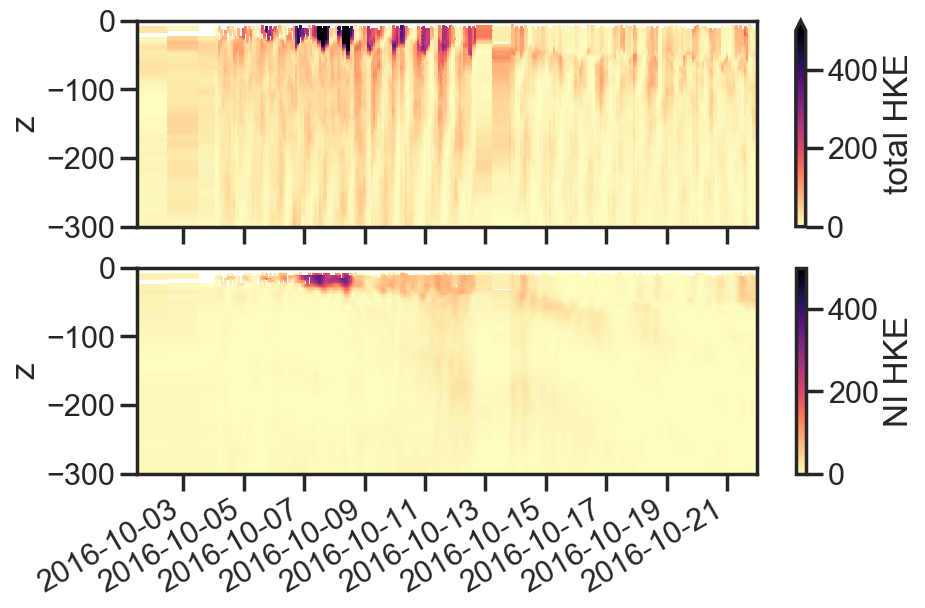

In [375]:
zmin = -300
f, (ax0, ax1) = plt.subplots(2,1,figsize=(10,6), sharex=True) 
raw.hkeTOT.where(mask).plot(cmap='magma_r',vmin=0, vmax=500, ax=ax0, cbar_kwargs={'label': 'total HKE'})
ax0.set_ylim(zmin,0)
ax0.set_xlabel(None)

raw.hkeNI.where(mask).plot(cmap='magma_r',vmin=0, vmax=500, ax=ax1, cbar_kwargs={'label': 'NI HKE'})
ax1.set_ylim(zmin,0)
ax1.set_xlabel(None);

In [382]:
# integrate energy vertically
zmin = -300
raw['mld'] = ('time', raw.z.where(raw.S2 == raw.S2.max(dim='z')).mean(dim='z'))
raw['hke_ml_ni'] = ('time', integrate_columns(raw.hkeNI, raw.mld,0))
raw['hke_py_ni'] = ('time', integrate_columns(raw.hkeNI, zmin, raw.mld))
raw['hke_ml'] = ('time', integrate_columns(raw.hkeTOT, raw.mld,0))
raw['hke_py'] = ('time', integrate_columns(raw.hkeTOT, zmin, raw.mld))

In [386]:
# just to check takes simple averages
ml_mask = (raw.z>raw.mld) & (raw.z<0)
py_mask = (raw.z>zmin) & (raw.z<raw.mld)
raw['hke_ml_ni'] = raw.hkeNI.where(ml_mask).mean(dim='z')
raw['hke_py_ni'] = raw.hkeNI.where(py_mask).mean(dim='z')
raw['hke_ml'] = raw.hkeTOT.where(ml_mask).mean(dim='z')
raw['hke_py'] = raw.hkeTOT.where(py_mask).mean(dim='z')

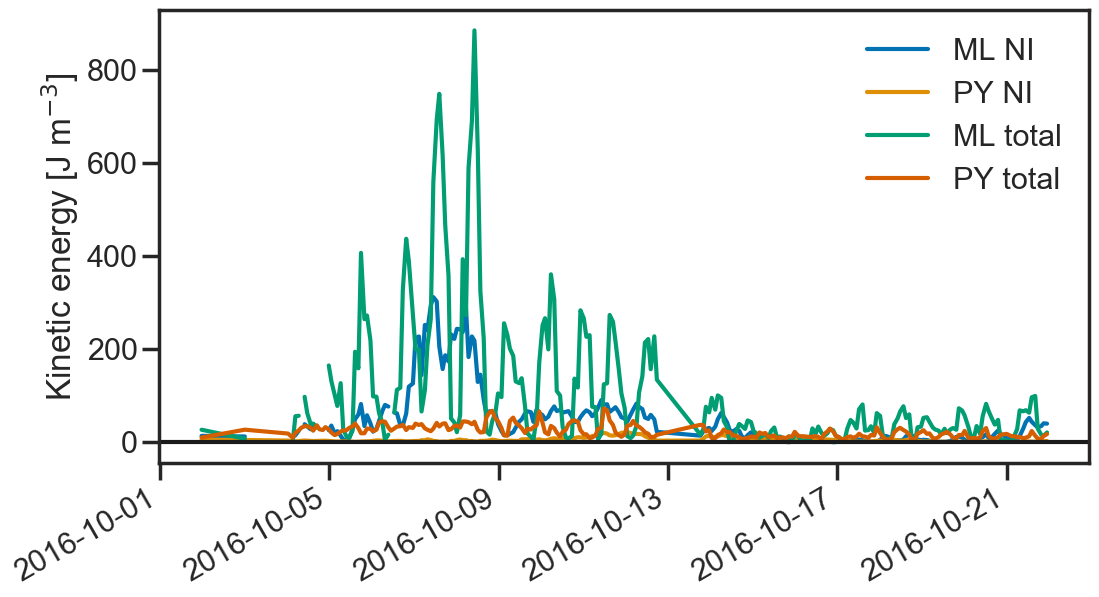

In [434]:
raw['hke_ml_ni'].plot(label='ML NI')
raw['hke_py_ni'].plot(label='PY NI')
raw['hke_ml'].plot(label='ML total')
raw['hke_py'].plot(label='PY total')
plt.ylabel('Kinetic energy [J m$^{-3}$]')
plt.xlabel(None)
plt.axhline(0, color='k')
plt.legend();

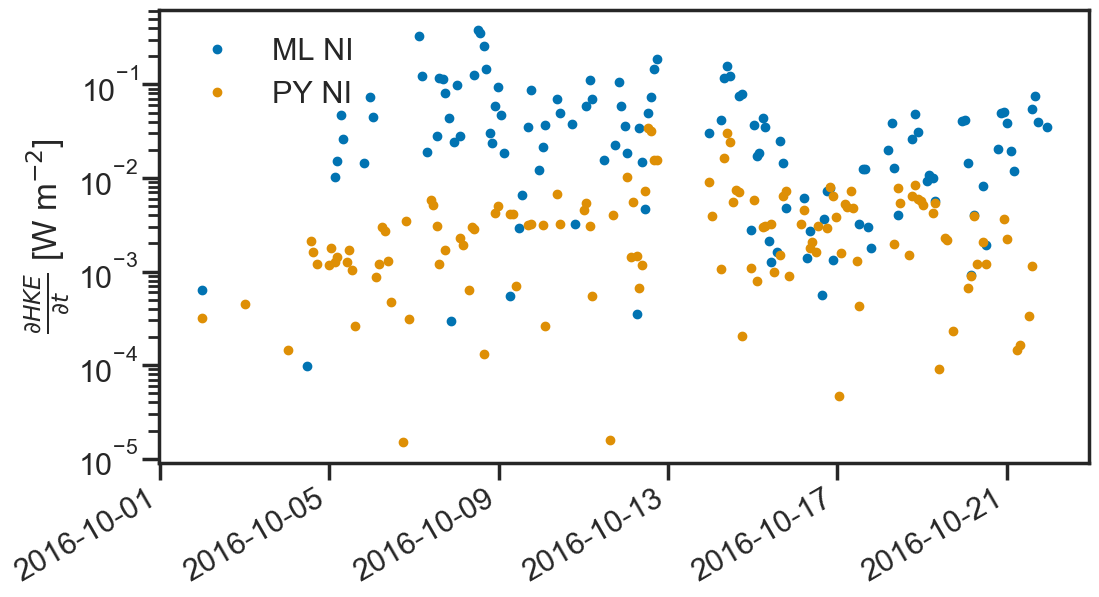

In [413]:
# take time derivatvies
raw['dhke_ml'] = (raw['hke_ml_ni']*raw.mld).differentiate('time',datetime_unit='s')
raw['dhke_py'] =(raw['hke_py_ni']*raw.mld).differentiate('time',datetime_unit='s')

raw.dhke_ml.plot(label='ML NI', marker='.', lw=0)
raw.dhke_py.plot(label='PY NI', marker='.', lw=0)

# (raw['hke_ml_ni'].differentiate('time',datetime_unit='s')*raw.mld).plot(label='ML NI')
# (raw['hke_py_ni'].differentiate('time',datetime_unit='s')*raw.mld).plot(label='PY NI')
# raw['hke_ml'].differentiate('time',datetime_unit='s').plot(label='ML total')
# raw['hke_py'].differentiate('time',datetime_unit='s').plot(label='PY total')

plt.ylabel(r'$\frac{\partial HKE}{\partial t}$ [W m$^{-2}$]')
plt.xlabel(None)
plt.legend();
plt.yscale('log')

## Wind work $\mathbf{\tau} \cdot \mathbf{u}$

In [407]:
cfs = xr.open_dataset('../data/metdata/float_cfs_hourly.nc')
cfs = cfs.sel(floatid=f'{floatid}')
cfs = cfs.interp_like(raw).sel(time=slice('2016-10-01','2016-10-21'))

In [408]:
# extract uppermost velocity measuremnt
indu = first_finite(raw.u, 0)
indv = first_finite(raw.v, 0)
raw['u_surf'] = raw.u[indu]
raw['v_surf'] = raw.v[indv]

# extract uppermost velocity measuremnt
indu = first_finite(raw.uNI, 0)
indv = first_finite(raw.vNI, 0)
raw['u_surf_ni'] = raw.uNI[indu]
raw['v_surf_ni'] = raw.vNI[indv]

raw['tx'] = ('time', -cfs['tx'])
raw['ty'] = ('time', -cfs['ty'])
raw['taudotu'] = raw.u_surf * raw.tx + raw.v_surf * raw.ty
raw['taudotu_ni'] = raw.u_surf_ni * raw.tx + raw.v_surf_ni * raw.ty
raw['tau'] = ('time', np.sqrt( raw.tx**2 + raw.ty**2 ))

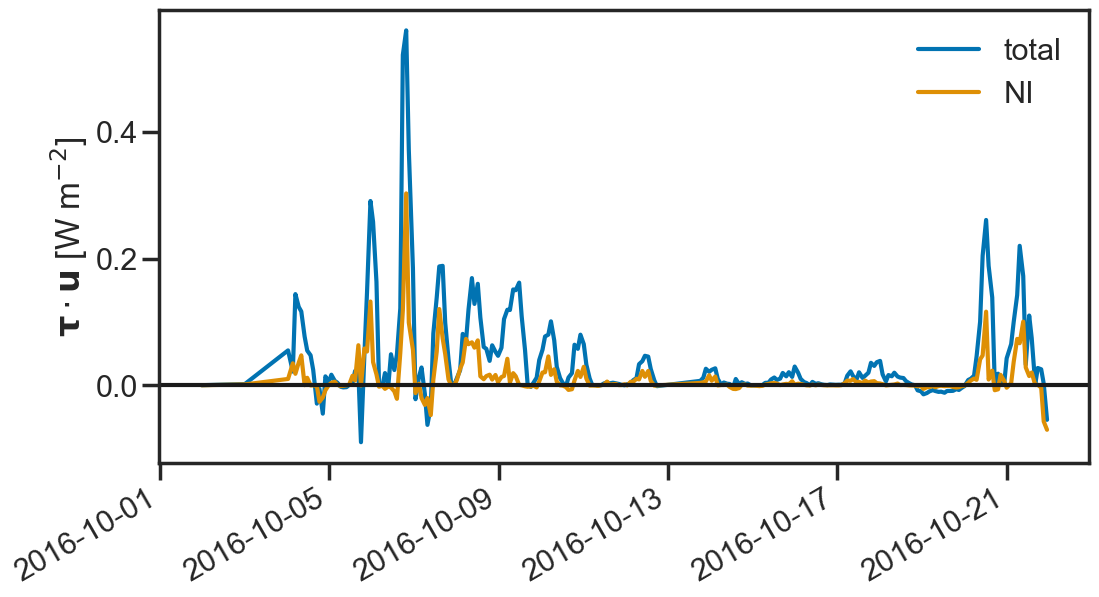

In [435]:
# raw.tau.sel(time=slice('2016-10-01','2016-10-21')).plot(label='tau')
raw.taudotu.plot(label='total')
raw.taudotu_ni.plot(label='NI')
plt.ylabel(r'$\mathbf{\tau} \cdot \mathbf{u}$ [W m$^{-2}$]')
plt.xlabel(None)
plt.axhline(0, color='k')
plt.legend()
# plt.yscale('log')

Text(0, 0.5, '$\\frac{\\partial HKE}{\\partial t}$ [W m$^{-2}$]')

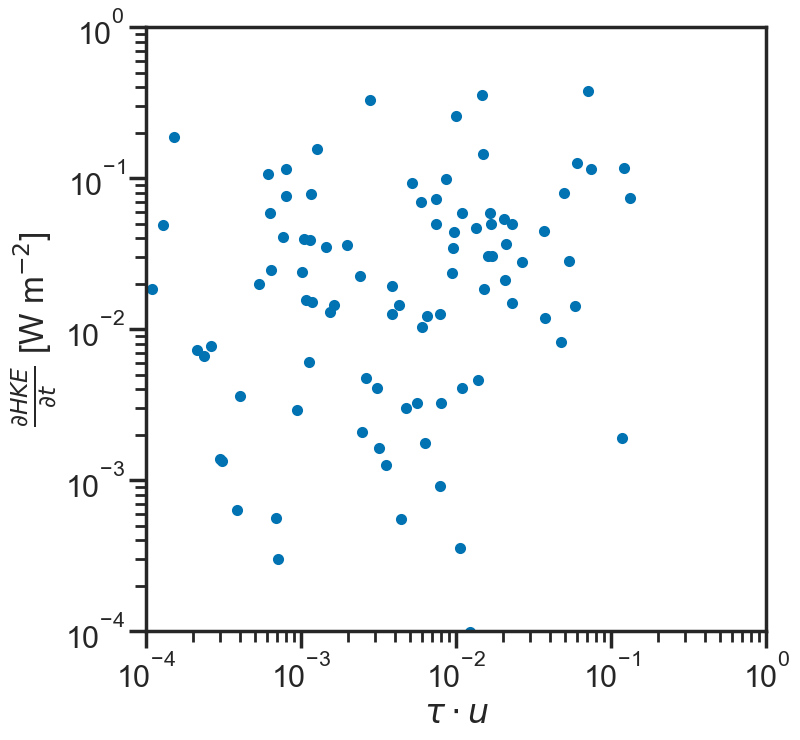

In [436]:
plt.figure(figsize=(8,8))
plt.scatter(raw.taudotu_ni,raw.dhke_ml, marker='.')
# plt.scatter(raw.taudotu,raw.dhke_ml, marker='.')
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-4,1e0)
plt.ylim(1e-4,1e0)
# plt.axis('equal')
plt.xlabel(r'$\tau \cdot u$')
plt.ylabel(r'$\frac{\partial HKE}{\partial t}$ [W m$^{-2}$]')

## Availabel potential energy (APE)

In [476]:
raw['rho_ref'] = raw.rho0.rolling(time=5, center=True).mean()
raw['rho_prime'] = raw.rho0 - raw.rho_ref

(-200, 0)

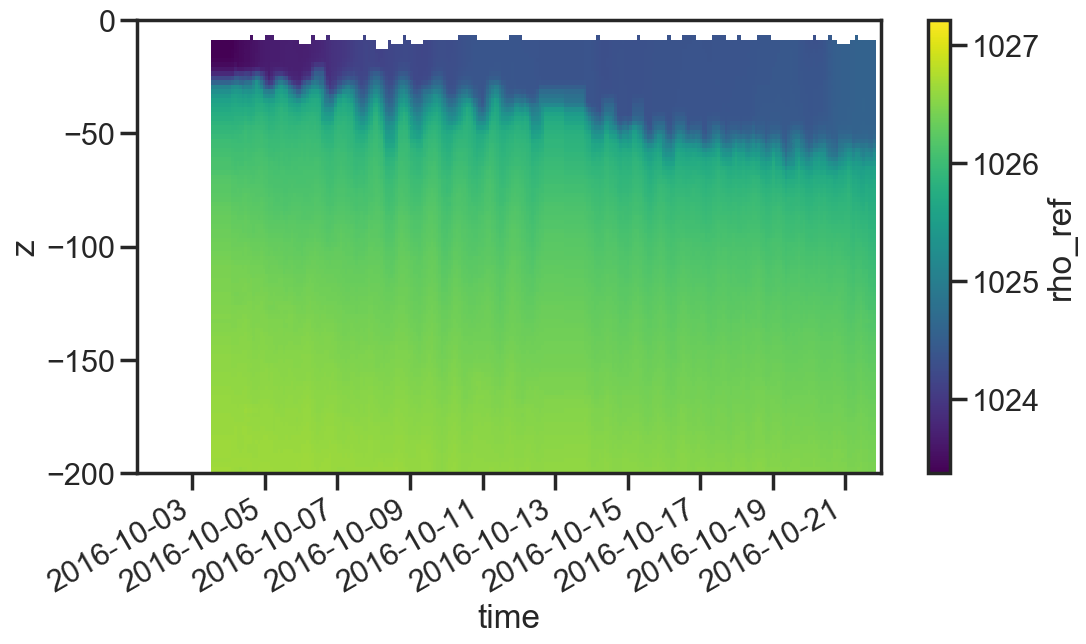

In [477]:
raw.rho_ref.plot()
plt.ylim(-200,0)

In [563]:
array = []
for t in range(raw.time.size):
    # TODO: could do better here with simpson's rule
    prof = raw.isel(time=t)
    prof = prof.dropna(dim='z', how='all', subset=['rho_ref'])
    prof = prof[['rho_ref','rho0','rho_prime']]
    proff = prof.swap_dims({'z':'rho_ref'})
    if prof.rho_ref.size>0:
        prof['zref'] = ('z', proff.interp(rho_ref=prof.rho0.values).z)
        prof['ape'] = ('z', compute_ape(prof) )
        array.append(prof)
    else:
        array.append(np.nan)
        
cleanedList = [x for x in array if type(x)!=float]
new = xr.concat(cleanedList, dim='time')